Load SNGAN model from PyTorch to TF2.  
SNGAN in Pytorch from [Mimicry Github Repo](https://github.com/kwotsin/mimicry).

In [1]:
# location of torch model and location for saving tf model
TF2_FILE = 'sngan-celeb_a-tf2-64/weights'
TORCH_FILE = 'nets/sngan-celeba-pt.pth'

In [2]:
############################
# ## SNGAN in TF2 Keras ## #
############################

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras

import math


class GenBlock(keras.layers.Layer):
    def __init__(self, in_channels, out_channels, hidden_channels=None, upsample=False):
        super(GenBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels if hidden_channels is not None else out_channels
        self.learnable_sc = in_channels != out_channels or upsample
        self.upsample = upsample

        self.conv_1 = keras.layers.Conv2D(filters=self.hidden_channels, kernel_size=3, padding="SAME")
        self.conv_2 = keras.layers.Conv2D(filters=out_channels, kernel_size=3, padding="SAME")

        self.bn_1 = keras.layers.BatchNormalization()
        self.bn_2 = keras.layers.BatchNormalization()

        self.relu = keras.activations.relu

        if self.learnable_sc:
            self.sc = keras.layers.Conv2D(filters=out_channels, kernel_size=1, padding="VALID")
        if self.upsample:
            self.upsampling_layer = keras.layers.UpSampling2D(interpolation='bilinear')

    def call(self, x, training=False):

        # residual layer
        h = x
        h = self.bn_1(h, training=training)
        h = self.relu(h)
        h = self.upsampling_layer(h) if self.upsample else h
        h = self.conv_1(h)
        h = self.bn_2(h, training=training)
        h = self.relu(h)
        h = self.conv_2(h)

        # shortcut
        y = x
        y = self.upsampling_layer(y) if self.upsample else y
        y = self.sc(y) if self.learnable_sc else y

        return h + y

class GenSNGAN64(keras.Model):
  def __init__(self, nz=128, ngf=1024, bottom_width=4):
    super().__init__()

    self.nz = nz
    self.ngf = ngf
    self.bottom_width = bottom_width

    # Build the layers
    self.lin_1 = keras.layers.Dense((self.bottom_width**2) * self.ngf)
    self.block2 = GenBlock(self.ngf, self.ngf >> 1, upsample=True)
    self.block3 = GenBlock(self.ngf >> 1, self.ngf >> 2, upsample=True)
    self.block4 = GenBlock(self.ngf >> 2, self.ngf >> 3, upsample=True)
    self.block5 = GenBlock(self.ngf >> 3, self.ngf >> 4, upsample=True)
    self.bn_6 = keras.layers.BatchNormalization()
    self.relu = keras.activations.relu
    self.conv_6 = keras.layers.Conv2D(filters=3, kernel_size=3, padding="SAME")

  def generate_latent_z(self, num_ims):
    return tf.random.normal([num_ims, self.nz])  # noise sample

  def generate_images(self, num_ims):
    z = self.generate_latent_z(num_ims)
    return self.call(z)

  def call(self, x, training=False):

    h = self.lin_1(x)
    h = tf.reshape(h, (-1, self.ngf, self.bottom_width, self.bottom_width))
    h = tf.transpose(h, (0, 2, 3, 1))
    h = self.block2(h, training=training)
    h = self.block3(h, training=training)
    h = self.block4(h, training=training)
    h = self.block5(h, training=training)
    h = self.bn_6(h, training=training)
    h = self.relu(h)
    h = self.conv_6(h)
    h = keras.activations.tanh(h)

    return h

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np


##########################
# ## SN GAN in Torch ## #
##########################

# code from: https://github.com/kwotsin/mimicry

class GBlock(nn.Module):
    r"""
    Residual block for generator.
    Uses bilinear (rather than nearest) interpolation, and align_corners
    set to False. This is as per how torchvision does upsampling, as seen in:
    https://github.com/pytorch/vision/blob/master/torchvision/models/segmentation/_utils.py
    Attributes:
        in_channels (int): The channel size of input feature map.
        out_channels (int): The channel size of output feature map.
        hidden_channels (int): The channel size of intermediate feature maps.
        upsample (bool): If True, upsamples the input feature map.
        num_classes (int): If more than 0, uses conditional batch norm instead.
        spectral_norm (bool): If True, uses spectral norm for convolutional layers.
    """
    def __init__(self, in_channels, out_channels, hidden_channels=None, upsample=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels if hidden_channels is not None else out_channels
        self.learnable_sc = in_channels != out_channels or upsample
        self.upsample = upsample

        # Build the layers
        # Note: Can't use something like self.conv = SNConv2d to save code length
        # this results in somehow spectral norm working worse consistently.
        self.c1 = nn.Conv2d(self.in_channels, self.hidden_channels, 3, 1, padding=1)
        self.c2 = nn.Conv2d(self.hidden_channels, self.out_channels, 3, 1, padding=1)

        self.b1 = nn.BatchNorm2d(self.in_channels)
        self.b2 = nn.BatchNorm2d(self.hidden_channels)

        self.activation = nn.ReLU(True)

        nn.init.xavier_uniform_(self.c1.weight.data, math.sqrt(2.0))
        nn.init.xavier_uniform_(self.c2.weight.data, math.sqrt(2.0))

        # Shortcut layer
        if self.learnable_sc:
            self.c_sc = nn.Conv2d(in_channels, out_channels, 1, 1, padding=0)
            nn.init.xavier_uniform_(self.c_sc.weight.data, 1.0)

    def _upsample_conv(self, x, conv):
        r"""
        Helper function for performing convolution after upsampling.
        """
        return conv(
            F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False))

    def _residual(self, x):
        r"""
        Helper function for feedforwarding through main layers.
        """
        h = x
        h = self.b1(h)
        h = self.activation(h)
        h = self._upsample_conv(h, self.c1) if self.upsample else self.c1(h)
        h = self.b2(h)
        h = self.activation(h)
        h = self.c2(h)

        return h

    def _shortcut(self, x):
        r"""
        Helper function for feedforwarding through shortcut layers.
        """
        if self.learnable_sc:
            x = self._upsample_conv(x, self.c_sc) if self.upsample else self.c_sc(x)
            return x
        else:
            return x

    def forward(self, x, y=None):
        r"""
        Residual block feedforward function.
        """
        if y is None:
            return self._residual(x) + self._shortcut(x)

        else:
            return self._residual_conditional(x, y) + self._shortcut(x)


class SNGANGenerator64(nn.Module):
    r"""
    ResNet backbone generator for SNGAN.
    Attributes:
        nz (int): Noise dimension for upsampling.
        ngf (int): Variable controlling generator feature map sizes.
        bottom_width (int): Starting width for upsampling generator output to an image.
        loss_type (str): Name of loss to use for GAN loss.
    """
    def __init__(self, nz=128, ngf=1024, bottom_width=4):
        super().__init__()
        self.nz = nz
        self.ngf = ngf
        self.bottom_width = bottom_width
        
        # Build the layers
        self.l1 = nn.Linear(self.nz, (self.bottom_width**2) * self.ngf)
        self.block2 = GBlock(self.ngf, self.ngf >> 1, upsample=True)
        self.block3 = GBlock(self.ngf >> 1, self.ngf >> 2, upsample=True)
        self.block4 = GBlock(self.ngf >> 2, self.ngf >> 3, upsample=True)
        self.block5 = GBlock(self.ngf >> 3, self.ngf >> 4, upsample=True)
        self.b6 = nn.BatchNorm2d(self.ngf >> 4)
        self.c6 = nn.Conv2d(self.ngf >> 4, 3, 3, 1, padding=1)
        self.activation = nn.ReLU(True)

        # Initialise the weights
        nn.init.xavier_uniform_(self.l1.weight.data, 1.0)
        nn.init.xavier_uniform_(self.c6.weight.data, 1.0)

    def forward(self, x):
        r"""
        Feedforwards a batch of noise vectors into a batch of fake images.
        Args:
            x (Tensor): A batch of noise vectors of shape (N, nz).
        Returns:
            Tensor: A batch of fake images of shape (N, C, H, W).
        """
        h = self.l1(x)
        h = h.view(x.shape[0], -1, self.bottom_width, self.bottom_width)
        h = self.block2(h)
        h = self.block3(h)
        h = self.block4(h)
        h = self.block5(h)
        h = self.b6(h)
        h = self.activation(h)
        h = torch.tanh(self.c6(h))

        return h

(8, 64, 64, 3)
Model: "gen_sngan64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  2113536   
                                                                 
 gen_block (GenBlock)        multiple                  7609856   
                                                                 
 gen_block_1 (GenBlock)      multiple                  1904384   
                                                                 
 gen_block_2 (GenBlock)      multiple                  477056    
                                                                 
 gen_block_3 (GenBlock)      multiple                  119744    
                                                                 
 batch_normalization_8 (Batc  multiple                 256       
 hNormalization)                                                 
                                        

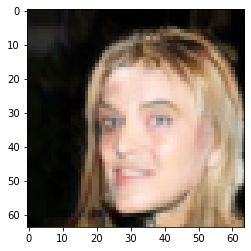

In [4]:
######################
# ## Build models ## #
######################

# make the tf model
model = GenSNGAN64()
model.trainable = False

# Build tf network. Sample random noise (z) and ImageNet label (y) inputs.
batch_size = 8
z = tf.random.normal([batch_size, 128])  # noise sample
# Call BigGAN on a dict of the inputs to generate a batch of images with shape
# [8, 128, 128, 3] and range [-1, 1].
samples = model(z)
print(samples.shape)

# tf model summary
model.summary()


# make the pytorch model and load the biggan weights from huggingface
model_pt = SNGANGenerator64()
model_pt.load_state_dict(torch.load(TORCH_FILE, map_location=torch.device('cpu'))['model_state_dict'])
model_pt.eval()
# visualize samples from loaded model
z = torch.randn([batch_size, 128])
samples_pt = model_pt(z)

import matplotlib.pyplot as plt
plt.imshow((samples_pt[0].permute(1, 2, 0).data.numpy()+1)/2)

In [5]:
#########################
# ## WEIGHT TRANSFER ## #
#########################

# function to copy linear layer
def list_linear_weights(layer_pt):
    weight_list = []
    # get pt weights
    weight_list += [np.transpose(layer_pt.weight.data.numpy())]
    if layer_pt.bias is not None:
        weight_list += [layer_pt.bias.data.numpy()]
    return weight_list

# function to copy conv layer
def list_conv_weights(layer_pt):
    weight_list = []

    # add to list
    weight_list += [np.transpose(layer_pt.weight.data.numpy(), (2, 3, 1, 0))]
    # save bias
    if layer_pt.bias is not None:
        weight_list += [layer_pt.bias.data.numpy()]

    return weight_list

# copy batchnorm layer
def list_batch_norm(layer_pt):
    weight_list = []

    # learning scaling and bias for standard batch norm
    weight_list += [layer_pt.weight.data.numpy()]
    weight_list += [layer_pt.bias.data.numpy()]
    # running mean and var records 
    weight_list += [layer_pt.running_mean.data.numpy()]
    weight_list += [layer_pt.running_var.data.numpy()]

    return weight_list

# copy gen block
def list_gen_block(layer_pt):
    # copy batchnorm layers
    bn_weight_list = []
    for i in range(1, 3):  #  Batchnorms
        batch_lyr_pt = getattr(layer_pt, 'b%d' % i)
        bn_weight_list += [list_batch_norm(batch_lyr_pt)]

    conv_weight_list = []
    for i in range(1, 3):  # Convolutions
        conv_lyr_pt = getattr(layer_pt, 'c%d' % i)
        conv_weight_list += [list_conv_weights(conv_lyr_pt)]
    
    sc_weight_list = []
    sc_lyr_pt = getattr(layer_pt, 'c_sc')
    sc_weight_list += [list_conv_weights(sc_lyr_pt)]

    return bn_weight_list, conv_weight_list, sc_weight_list


# copy embeddings
print('Initial linear layer.')
linear_1 = list_linear_weights(model_pt.l1)
model.lin_1.set_weights(linear_1)

# copy generator layers and attention layer
for i in range(2, 6):
    print('Loading Gen Block layer:', i)
    # get numpy list of weights
    bn_weights, conv_weights, sc_weights = list_gen_block(getattr(model_pt, 'block%d' % i))
    # load the bn weights
    for j in range(1, 3):
        print('\tLoading bn block: ', j)
        bn_layer_tf = getattr(getattr(model, 'block%d' % i), 'bn_' + str(j))
        bn_layer_tf.set_weights(bn_weights[j-1])
    # load the conv weights
    for j in range(1, 3):
        print('\tLoading conv block: ', j)
        conv_lyr_tf = getattr(getattr(model, 'block%d' % i), 'conv_' + str(j))
        conv_lyr_tf.set_weights(conv_weights[j-1])
    # load sc weights
    sc_lyr_tf = getattr(getattr(model, 'block%d' % i), 'sc')
    sc_lyr_tf.set_weights(sc_weights[0])

# copy final batch norm
print('Loading final batch norm.')
bn_weights = list_batch_norm(model_pt.b6)
model.bn_6.set_weights(bn_weights)
# copy rgb conv
print('Loading final conv layer.')
conv_to_rgb_weights = list_conv_weights(model_pt.c6)
model.conv_6.set_weights(conv_to_rgb_weights)

Initial linear layer.
Loading Gen Block layer: 2
	Loading bn block:  1
	Loading bn block:  2
	Loading conv block:  1
	Loading conv block:  2
Loading Gen Block layer: 3
	Loading bn block:  1
	Loading bn block:  2
	Loading conv block:  1
	Loading conv block:  2
Loading Gen Block layer: 4
	Loading bn block:  1
	Loading bn block:  2
	Loading conv block:  1
	Loading conv block:  2
Loading Gen Block layer: 5
	Loading bn block:  1
	Loading bn block:  2
	Loading conv block:  1
	Loading conv block:  2
Loading final batch norm.
Loading final conv layer.


In [6]:
##################
# ## TEST OUT ## #
##################

batch_size = 8

# tf2 noise and label
z_init = tf.random.normal([batch_size, 128])  # noise sample

# copy noise and label to torch via numpy
z_init_np = z_init.numpy()
z_init_pt = torch.tensor(z_init_np)

In [7]:
# forward pass with tf2 and torch biggan
im = model(z_init, training=False)
im_pt = model_pt(z_init_pt)

# max pixel-wise difference
print('Max pixel-wise difference between TF2 and Pytorch Big GAN:',
      np.max(np.abs(im.numpy() - im_pt.permute(0, 2, 3, 1).detach().numpy())))

Max pixel-wise difference between TF2 and Pytorch Big GAN: 0.052351356


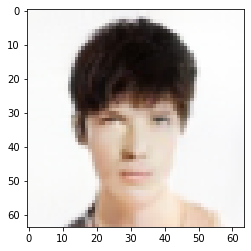

In [8]:
import matplotlib.pyplot as plt

# visual tf2 biggan
plt.imshow((im[0].numpy()+1)/2)

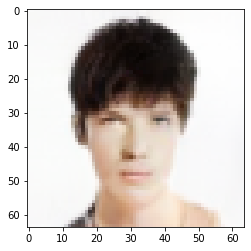

In [9]:
# visual torch biggan
plt.imshow((im_pt[0].permute(1, 2, 0).data.numpy()+1)/2)

In [10]:
# save tf2 weights
model.save_weights(TF2_FILE)